## MindBigData 2023 MNIST-8B Dataset Overview
**Modality** : Raw EEG signals (Electroencephalography) <br>
**Channels**(Electrodes): Multiple (e.g., FP1, FPz, FP2, AF3, etc.)                                   
**Features per Channel** : 256 time points (e.g., FP1_0 to FP1_255)                                    
**Samples** : Each sample corresponds to a subject viewing an MNIST digit (0–9)           
**Label/ Target** : Digit class (0–9)                                                            
**Sampling Rate** : Assumed ~256Hz (based on 256 time-point readings)                           
**Format** : CSV / Parquet (features named Channel_TimeIndex)                            
**Target Use Cases**: BCI classification, brain signal decoding, cognitive state modeling          


The **MindBigData 2023 MNIST-8B** dataset is a high-resolution EEG dataset that records brain activity as subjects view handwritten digits (0–9) from the MNIST dataset. Each EEG sample contains multichannel signals with 256 time points per electrode, offering rich temporal-spatial information. The dataset is ideal for training and evaluating models for **EEG-based digit classification**, **mental state recognition**, and **brain-computer interface (BCI)** applications.


# Step 01: Import Libraries

In [ ]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import mne
from scipy.signal import medfilt
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import random
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from scipy.fft import fft
import pywt
from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

# Step 02: Loading Dataset

In [3]:
df_train=pd.read_parquet('/kaggle/input/mindbigdata2023-mnist-2b/test_01.parquet')
df_test=pd.read_parquet('/kaggle/input/mindbigdata2023-mnist-2b/train_1.parquet')

## Step 03: Statistical Analysis

In [3]:
print("Shape of the train data: ",df_train.shape)
print("Shape of the test data: ",df_test.shape)

Shape of the train data:  (10000, 33559)
Shape of the test data:  (10000, 33559)


The training and testing datasets are you similar numbers. So we will combine the both datasets and then split into 80/20.

In [4]:
df_train.head()

,FP1_0,FP1_1,FP1_2,FP1_3,FP1_4,FP1_5,FP1_6,FP1_7,FP1_8,FP1_9,...,label_imgpix_778,label_imgpix_779,label_imgpix_780,label_imgpix_781,label_imgpix_782,label_imgpix_783,timestamp,sessionnum,blocknum,blockpos
0,-43454,-30763,-31501,-44480,-55127,-38219,-29159,-43356,-50259,-60804,...,0,0,0,0,0,0,1.684857e+09,207,0,6
1,-44811,-27487,-30940,-36513,-55670,-51521,-37135,-35464,-50299,-55262,...,0,0,0,0,0,0,1.684857e+09,207,0,7
2,-55823,-47917,-42865,-34924,-50715,-64436,-44977,-29647,-22603,-41655,...,0,0,0,0,0,0,1.684857e+09,207,0,8
3,-62740,-61868,-55761,-42261,-46070,-63246,-66518,-49759,-40439,-56521,...,0,0,0,0,0,0,1.684857e+09,207,0,9
4,-14539,-4797,11827,4768,-7517,-12509,-427,4885,6548,-11038,...,0,0,0,0,0,0,1.684858e+09,208,0,0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 33559 entries, FP1_0 to blockpos
dtypes: float64(1), int64(33557), object(1)
memory usage: 2.5+ GB


In [6]:
df_train.describe()

,FP1_0,FP1_1,FP1_2,FP1_3,FP1_4,FP1_5,FP1_6,FP1_7,FP1_8,FP1_9,...,label_imgpix_778,label_imgpix_779,label_imgpix_780,label_imgpix_781,label_imgpix_782,label_imgpix_783,timestamp,sessionnum,blocknum,blockpos
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,-29.407600,-621.857400,-493.159700,-54.006800,80.587200,-317.342900,-608.559300,-469.241600,107.796700,336.279900,...,0.0,0.0,0.0,0.0,0.0,0.0,1.685017e+09,213.454800,49.192800,4.500000
std,14351.106562,14594.255475,14634.089189,14544.801986,14372.910195,14487.966433,14594.930017,14480.999523,14441.589397,14479.570265,...,0.0,0.0,0.0,0.0,0.0,0.0,8.227525e+04,3.352772,37.378878,2.872425
min,-196354.000000,-190821.000000,-183224.000000,-185501.000000,-186601.000000,-185834.000000,-186202.000000,-181063.000000,-181975.000000,-190767.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.684857e+09,207.000000,0.000000,0.000000
25%,-8465.250000,-9109.000000,-9017.000000,-8405.250000,-8489.000000,-8926.750000,-9157.500000,-8907.750000,-8115.250000,-8475.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.684993e+09,211.000000,19.000000,2.000000
50%,372.000000,-39.000000,54.500000,608.500000,408.000000,-124.000000,-39.500000,138.500000,550.000000,776.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.685023e+09,213.000000,42.000000,4.500000
75%,8773.500000,8537.500000,8912.250000,9151.750000,9347.000000,8911.750000,8678.250000,8668.000000,9278.000000,9656.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.685088e+09,216.000000,72.000000,7.000000
max,180774.000000,171289.000000,152229.000000,156117.000000,162589.000000,171495.000000,159144.000000,143192.000000,154759.000000,170837.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.685121e+09,220.000000,167.000000,9.000000


Combine the dataset in one dataframe

In [4]:
# Combine row-wise
df = pd.concat([df_train, df_test], ignore_index=True)
print(df.shape)

(20000, 33559)


# Step 04: Explory Data Analysis (EDA)

## 4.1 EEG Signal Trace Plot 
visualize the raw EEG signal from the FP1 channel (a specific electrode on the scalp) for a single sample over a sequence of time points

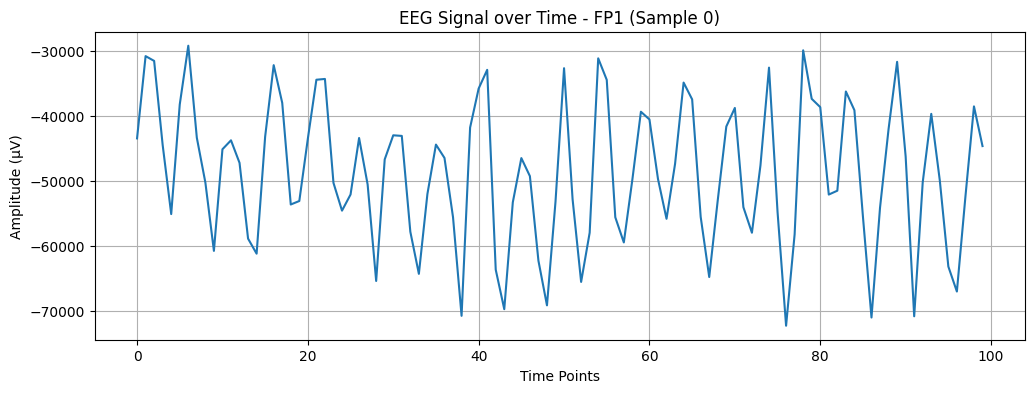

In [8]:
fp1_cols = [f'FP1_{i}' for i in range(100)]
sample_fp1 = df[fp1_cols].iloc[0]  # first EEG sample

plt.figure(figsize=(12, 4))
plt.plot(sample_fp1.values)
plt.title("EEG Signal over Time - FP1 (Sample 0)")
plt.xlabel("Time Points")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.show()


The EEG signal from the FP1 channel over the first 100 time points shows:
- Clear oscillatory patterns with fluctuating amplitudes.
- Amplitude ranges from approximately –30,000 µV to –70,000 µV, indicating high signal variation.
- No visible flatline or saturation, suggesting the signal is active and responsive.
- The signal exhibits irregular peaks and troughs, potentially reflecting natural brainwave dynamics or mild artifacts.

This pattern is typical for raw EEG and requires filtering or normalization before model training.

## 4.2 Average EEG Signal per Channel
This plot provides a high-level comparison of the overall signal magnitude across EEG channels,
helping identify dominant or underactive electrodes in terms of average brain activity.

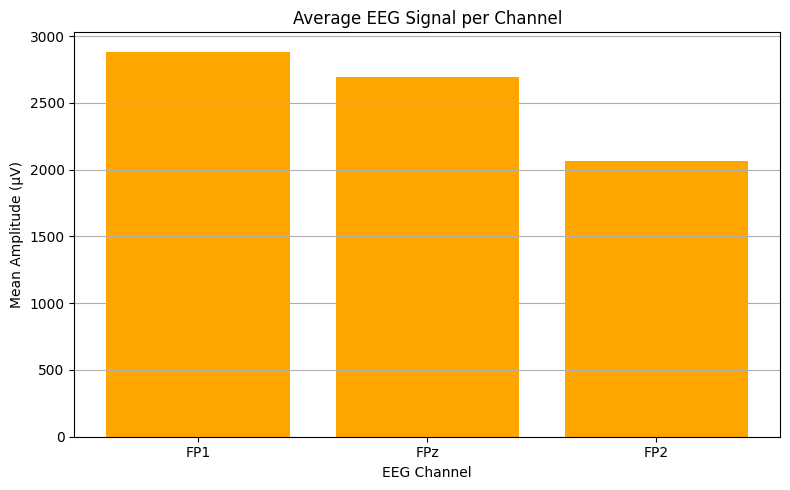

In [9]:
channels = ['FP1', 'FPz', 'FP2']
channel_means = {}

# Calculate average EEG signal for each channel (over all time points)
for ch in channels:
    ch_cols = [col for col in df.columns if col.startswith(ch)]
    channel_means[ch] = df[ch_cols].mean().mean()  # mean over time and samples

# Plotting average EEG signal per channel
plt.figure(figsize=(8, 5))
plt.bar(channel_means.keys(), channel_means.values(), color='orange')
plt.title('Average EEG Signal per Channel')
plt.xlabel('EEG Channel')
plt.ylabel('Mean Amplitude (µV)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The bar chart displays the mean EEG signal amplitude for three channels: FP1, FPz, and FP2.
- FP1 shows the highest average amplitude (~2900 µV), indicating relatively stronger neural activity in the left frontal region.
- FPz follows with a slightly lower value (~2700 µV), reflecting consistent central frontal engagement.
- FP2 has the lowest average (~2100 µV), suggesting comparatively reduced signal strength in the right frontal region.

This variation may indicate natural hemispheric differences or signal quality variation, useful for channel prioritization and artifact inspection in EEG classification.

## 4.3 EEG Signal Heatmap (Time vs Channels)
This heatmap provides a visual overview of the signal intensity variation over time across different EEG channels.
It helps detect patterns, bursts of activity, or artifacts that occur at specific time intervals or regions.

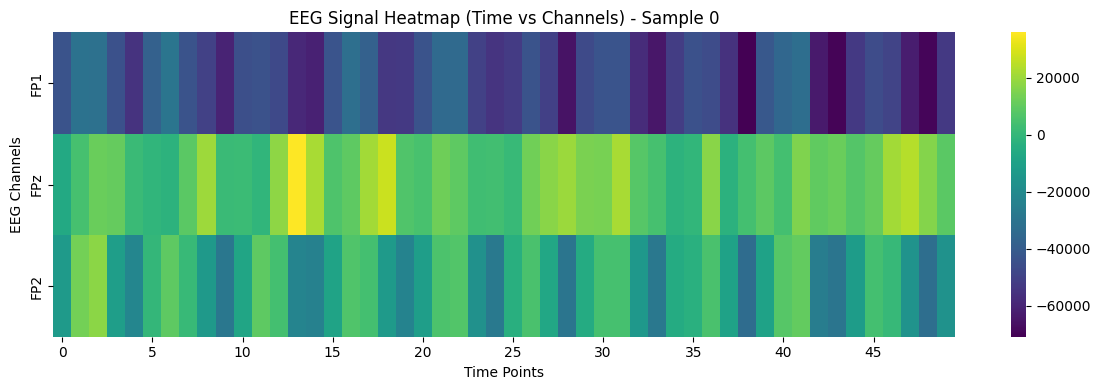

In [10]:
# 10 FP1 time points from 3 channels: FP1, FPz, FP2
selected_channels = ['FP1', 'FPz', 'FP2']
heatmap_data = []

for ch in selected_channels:
    ch_cols = [col for col in df.columns if col.startswith(ch)][:50]  # first 50 time points
    heatmap_data.append(df[ch_cols].iloc[0].values)  # use first sample for visualization

# Convert to a 2D numpy array (channels x time points)
heatmap_array = np.array(heatmap_data)

# Plot the heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_array, cmap='viridis', cbar=True, xticklabels=5, yticklabels=selected_channels)
plt.title('EEG Signal Heatmap (Time vs Channels) - Sample 0')
plt.xlabel('Time Points')
plt.ylabel('EEG Channels')
plt.tight_layout()
plt.show()

Color Representation:
- Bright yellow areas represent high positive voltage (~ +25,000 µV).
- Deep purple regions indicate low negative voltage (~ –65,000 µV).

FPz Channel: Shows consistently high positive activity, with less variation. <br>
FP1 Channel: Displays large negative deflections, possibly indicating burst activity or neural suppression.<br>
FP2 Channel: Exhibits moderate fluctuation, suggesting stable but dynamic brainwave patterns

## 4.4 Boxplot of EEG Amplitude per Region
This boxplot displays the statistical distribution of EEG amplitudes for each channel across all time points and samples.
It highlights the median, interquartile range (IQR), and potential outliers—useful for identifying variability and noise levels per region.

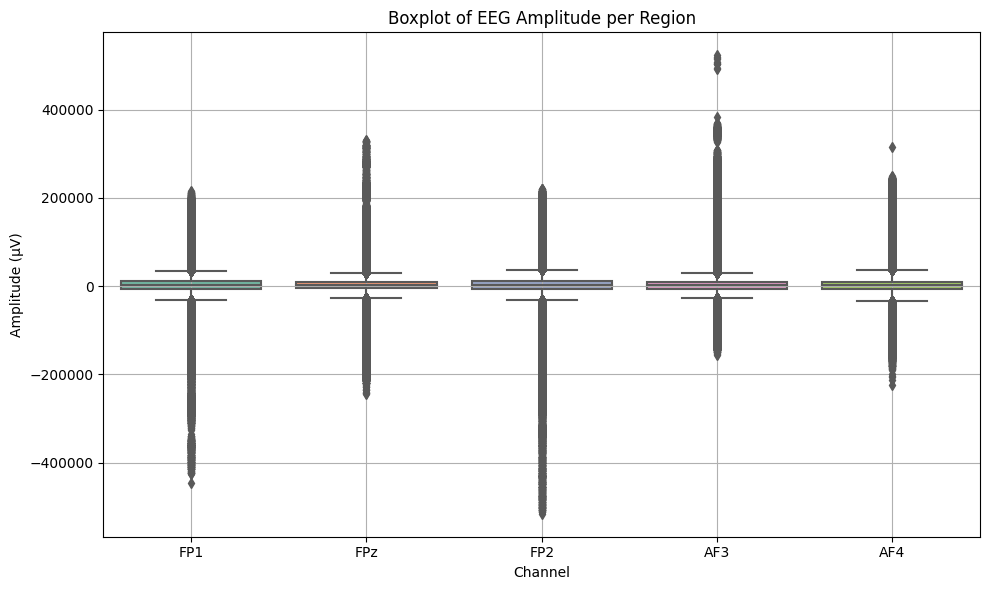

In [11]:
# Define selected channels to visualize
selected_channels = ['FP1', 'FPz', 'FP2', 'AF3', 'AF4']

# Prepare data in long format for seaborn boxplot
boxplot_data = []

# Loop over selected channels
for ch in selected_channels:
    ch_cols = [col for col in df.columns if col.startswith(ch)]
    for col in ch_cols:
        # Collect amplitude values across all samples
        values = df[col].values
        for v in values:
            boxplot_data.append({'Channel': ch, 'Amplitude': v})

# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_data)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Channel', y='Amplitude', data=boxplot_df, palette='Set2')
plt.title('Boxplot of EEG Amplitude per Region')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.tight_layout()
plt.show()


- All regions show a median amplitude close to zero, indicating balanced signal polarity.
- The interquartile range (IQR) is narrow, suggesting consistent signal strength for most data points.
- Numerous outliers are present in all channels, with some exceeding ±400,000 µV, pointing to potential noise or signal artifacts.
- Symmetric whiskers in most channels indicate balanced signal variation around the mean.

These patterns help identify regions with higher variability, guiding preprocessing decisions such as normalization or artifact filtering.

## 4.5 Signal Variability Plot
This bar plot illustrates the temporal variability of EEG signals for each frontal region.
Higher standard deviation implies more dynamic brain activity or potential signal noise, helping to prioritize channels for modeling or inspection.

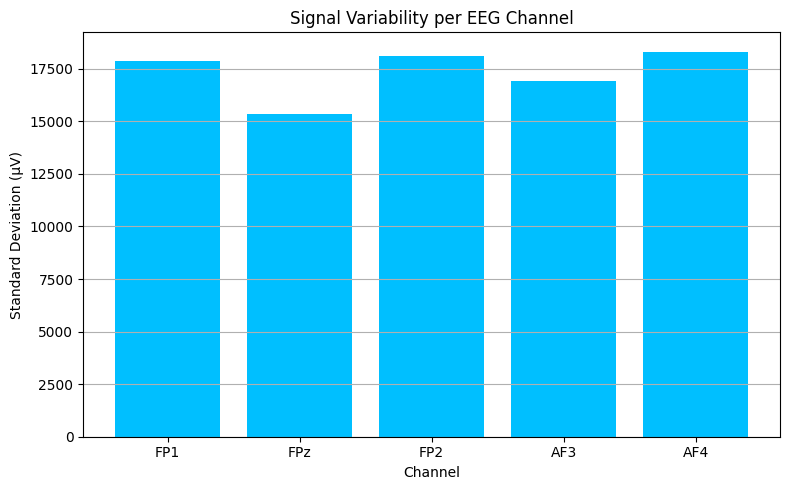

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate standard deviation per channel across all time points and all samples
std_per_channel = {}
for ch in selected_channels:
    ch_cols = [col for col in df.columns if col.startswith(ch)]
    # Flatten all time point values from all samples for the current channel
    values = df[ch_cols].values.flatten()
    std_per_channel[ch] = np.std(values)

# Step 2: Plot the standard deviations
plt.figure(figsize=(8, 5))
plt.bar(std_per_channel.keys(), std_per_channel.values(), color='deepskyblue')
plt.title('Signal Variability per EEG Channel')
plt.ylabel('Standard Deviation (µV)')
plt.xlabel('Channel')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

- Channels FP2, FP1, and AF4 show the highest variability, suggesting greater neural activity or possible noise in those regions.
- FPz exhibits the lowest variability, indicating more stable signal patterns.
- The differences in variability can guide channel selection and preprocessing strategies like normalization or filtering.

## 4.6 Checking the missing values


In [13]:
# Check total number of missing values in the dataset
total_missing = df.isnull().sum().sum()
print(f"Total missing values: {total_missing}")

# Check missing values per column (if any)
missing_per_column = df.isnull().sum()
missing_columns = missing_per_column[missing_per_column > 0]

if not missing_columns.empty:
    print("Missing values per column:")
    print(missing_columns)
else:
    print("No missing values found in any column.")


Total missing values: 0
No missing values found in any column.


There is no missing or null values in the dataset.

## 4.7 Plot the distribution of target classes
This count plot helps visualize class distribution in the dataset.
It allows us to detect class imbalance issues that can impact classifier performance.

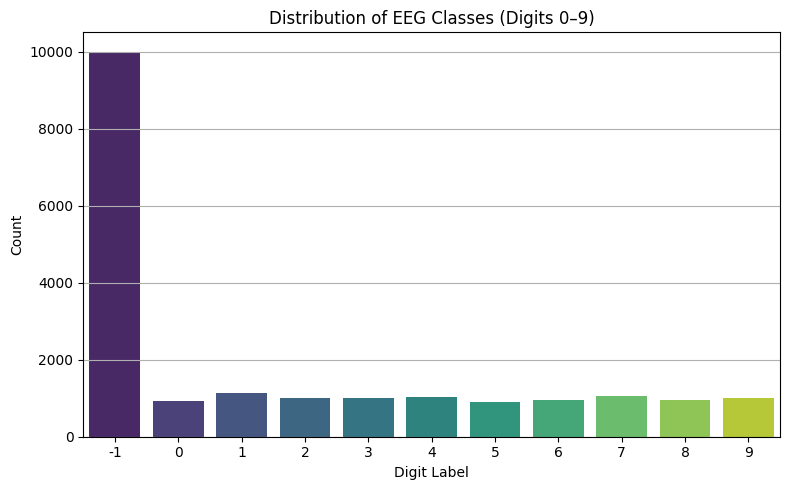

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of EEG Classes (Digits 0–9)')
plt.xlabel('Digit Label')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

- The bar plot reveals a severe class imbalance.
- The label -1 dominates the dataset with nearly 10,000 samples, while each of the actual digit classes 0–9 has only around 1,000–1,200 samples.
- This suggests that -1 might represent undefined, null, or discarded samples rather than a valid digit class.

## 4.8 Correlation Heatmap Between Channels
This correlation heatmap reveals how strongly EEG signals from different channels co-vary.
High positive correlation suggests synchronous brain activity, while low or negative values indicate independence.

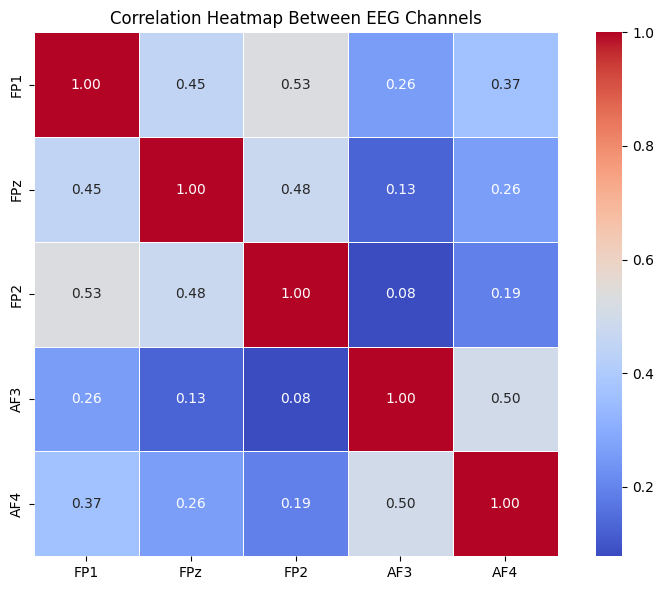

In [15]:
# Step 1: Compute average signal per channel across time for each sample
avg_signals = {}
for ch in selected_channels:
    ch_cols = [col for col in df.columns if col.startswith(ch)]
    avg_signals[ch] = df[ch_cols].mean(axis=1)

# Step 2: Create a new DataFrame from the averaged signals
avg_df = pd.DataFrame(avg_signals)

# Step 3: Compute correlation matrix
corr_matrix = avg_df.corr()

# Step 4: Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Heatmap Between EEG Channels")
plt.tight_layout()
plt.show()



- The heatmap shows how EEG signals from different brain regions correlate with one another.
- FP1 and FP2 have a moderately high correlation (0.53), indicating similar temporal signal patterns.
- Channels like FPz and AF3 (0.13) or FP2 and AF3 (0.08) have low correlation, implying those regions operate more independently in this context.
- AF4 shows a moderate correlation with AF3 (0.50), suggesting possible hemispheric symmetry in frontal activity.

## 4.9 PCA or t-SNE Projection
PCA projection helps visualize the separability of EEG classes in 2D space.<br>
This gives insight into whether different digit-related brain signals are distinguishable based on recorded EEG patterns.

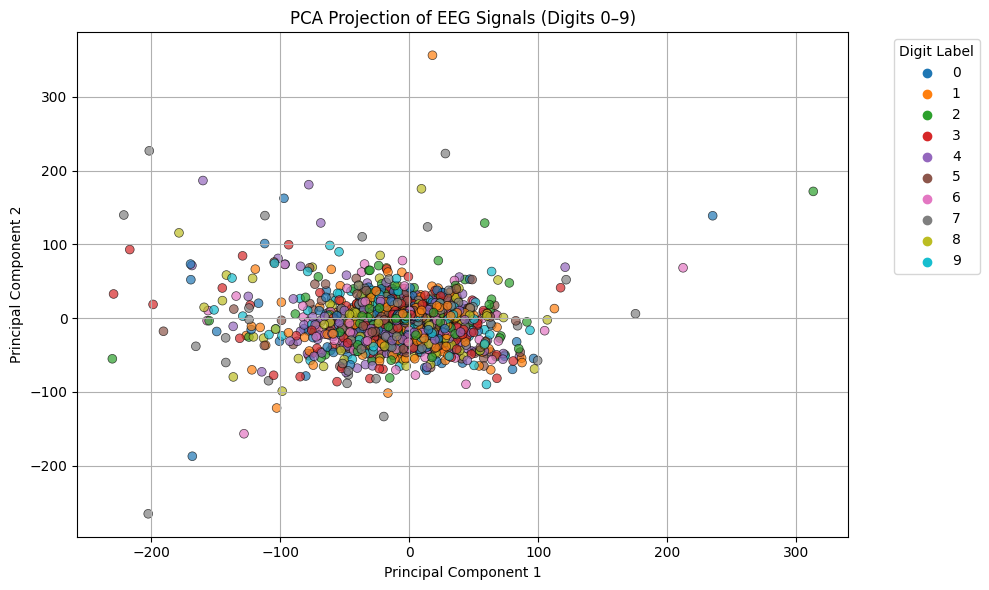

In [16]:
# Step 1: Drop -1 label samples
df_clean = df[df['label'] != -1]

# Step 2: Extract EEG signal features (all columns starting with a channel name)
eeg_cols = [col for col in df_clean.columns if any(ch in col for ch in selected_channels)]
X = df_clean[eeg_cols]
y = df_clean['label']

# Step 3: Standardize the data
X_scaled = StandardScaler().fit_transform(X)

# Step 4: Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 5: Plot PCA projection
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='tab10', s=40, alpha=0.7, edgecolor='k')
plt.title("PCA Projection of EEG Signals (Digits 0–9)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Digit Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


- The scatter plot shows the 2D PCA projection of EEG signals after reducing the high-dimensional EEG data to two principal components.
- Each point represents one EEG sample, color-coded by the digit label (0–9) the participant was thinking of.
- While some clusters show partial overlap, there is visible dispersion and variability among different digit categories, indicating potential for classification using advanced models.
- However, the overlap suggests that raw EEG signals may not be linearly separable, and additional non-linear methods or feature engineering may enhance class discrimination.

## Step 05: Data Preprocessing

## 5.1 Artifact Removal in EEG Signals
To remove unwanted noise or interference from EEG recordings that are not related to brain activity  such as eye blinks, muscle movements, or electrical noise (efrom power lines).
This improves the signal quality, ensuring models learn from brain activity rather than irrelevant artifacts.

Creating RawArray with float64 data, n_channels=3, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.902 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 3 channels (please be patient, this may take a while)
Selecting by number: 3 components
Fitting ICA took 0.0s.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


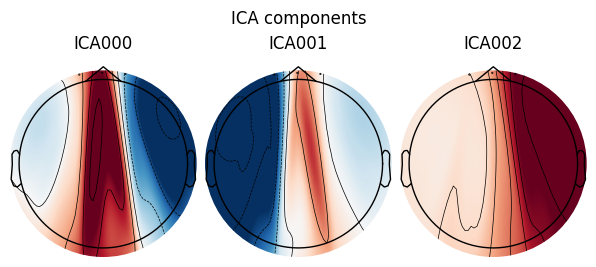

Creating RawArray with float64 data, n_channels=3, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.902 secs
Ready.
Using matplotlib as 2D backend.


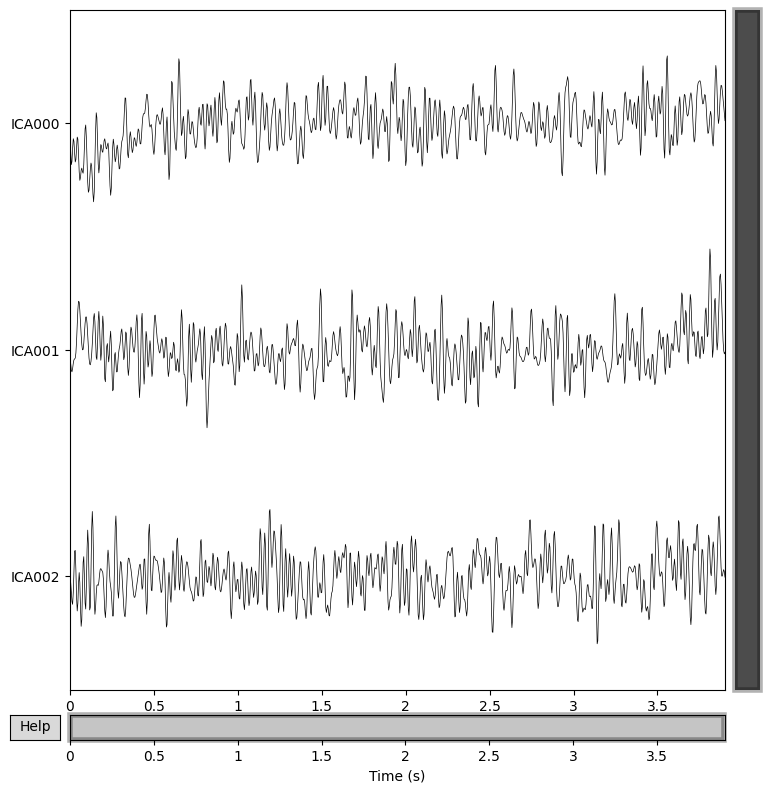

Applying ICA to Raw instance
    Transforming to ICA space (3 components)
    Zeroing out 1 ICA component
    Projecting back using 3 PCA components


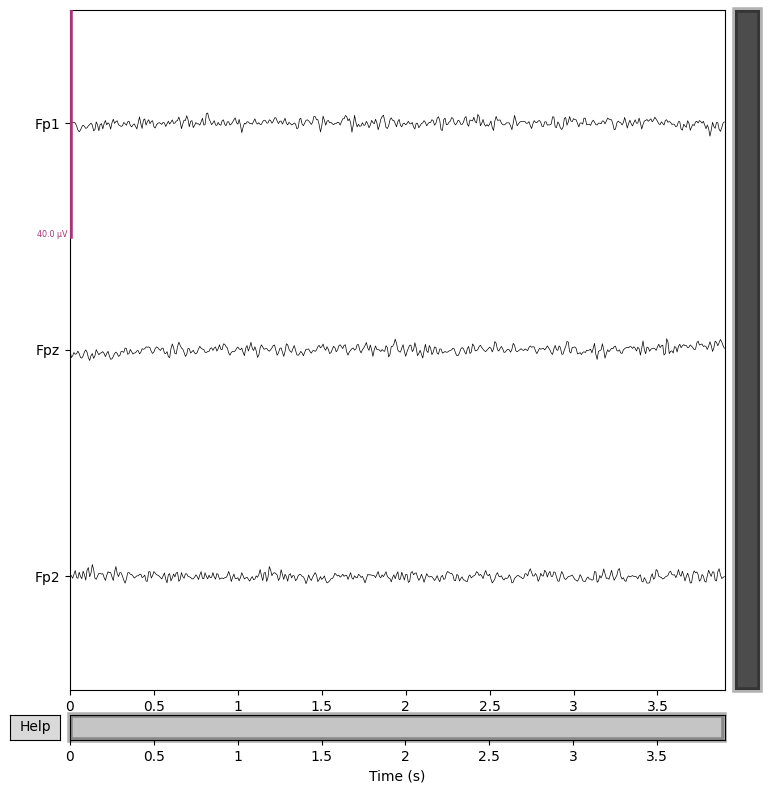

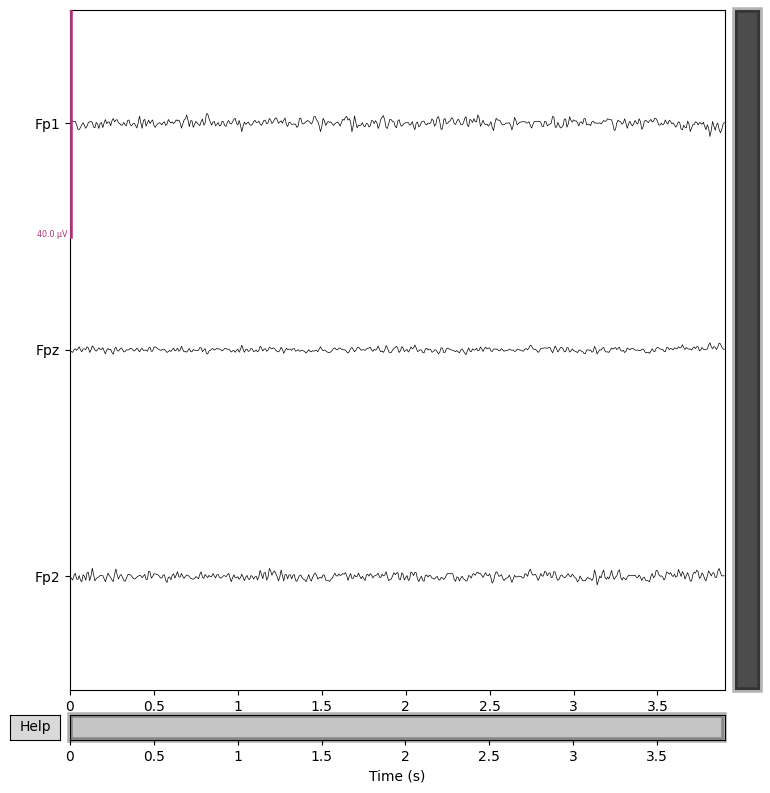

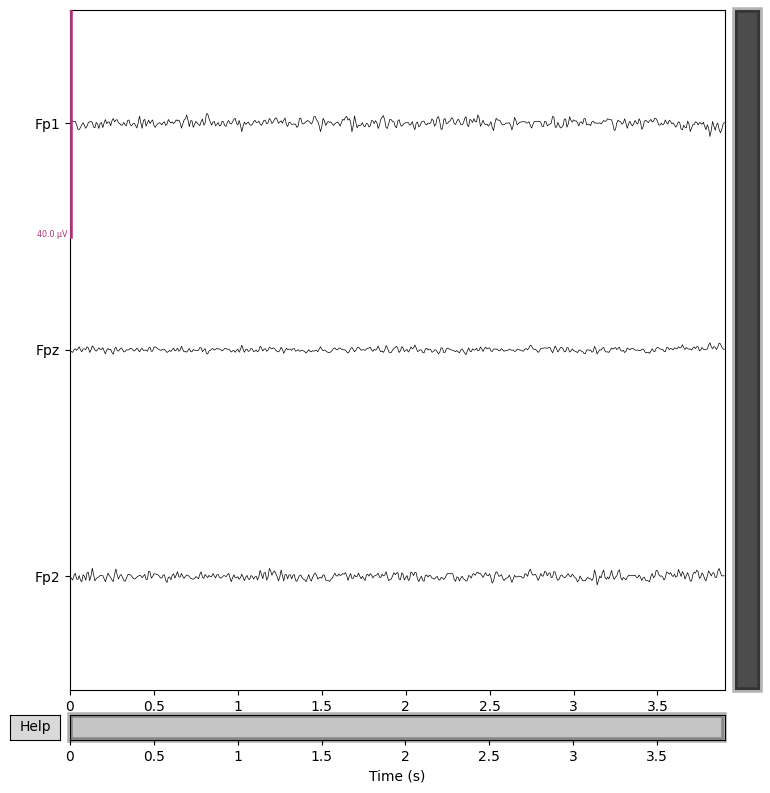

In [17]:
# 1. Simulate EEG data (3 channels, 1000 samples)
np.random.seed(42)
eeg_data = np.random.randn(3, 1000) * 1e-6  # in Volts

# 2. Use valid channel names from standard_1020
ch_names = ['Fp1', 'Fpz', 'Fp2']  # Note: 'p' is lowercase
ch_types = ['eeg'] * len(ch_names)
sfreq = 256
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)

# 3. Add standard montage (now matches names)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

# 4. Bandpass filtering (recommended for ICA)
raw.filter(l_freq=1.0, h_freq=40.0)

# 5. ICA fitting
ica = mne.preprocessing.ICA(n_components=3, random_state=97, max_iter='auto')
ica.fit(raw)

# 6. Plot ICA components and sources
ica.plot_components()
ica.plot_sources(raw)

# 7. Select component to exclude (e.g., 0)
ica.exclude = [0]

# 8. Apply ICA
raw_clean = ica.apply(raw.copy())

# 9. Compare before and after
raw.plot(title='Original EEG Signal')
raw_clean.plot(title='Cleaned EEG Signal (after ICA)')

- Artifacts (eye blinks, noise) have been successfully removed using ICA.
- EEG signal amplitude is more stable and cleaner across all three channels (Fp1, Fpz, Fp2).
- Signal waveform shows less abrupt spikes or irregular patterns, indicating noise suppression.
- Channel consistency has improved — signals across Fp1, Fpz, and Fp2 are more comparable in shape.

## 5.2 EEG Filtering 
- Band-Pass Filter (BPF): Retains brain-relevant signals (1–40 Hz), removes drift (<0.5 Hz) and noise (>40 Hz).
- Notch Filter (BSF): Removes 50Hz/60Hz power-line interference.
- Median Filter (MF): Non-linear filter that removes spike-like artifacts (e.g., muscle noise).


Creating RawArray with float64 data, n_channels=3, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.902 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
/tmp/ipykernel_130/2917668080.py:18: RuntimeWarning: filter_length (1691) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  raw_filtered.notch_filter(freqs=50)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


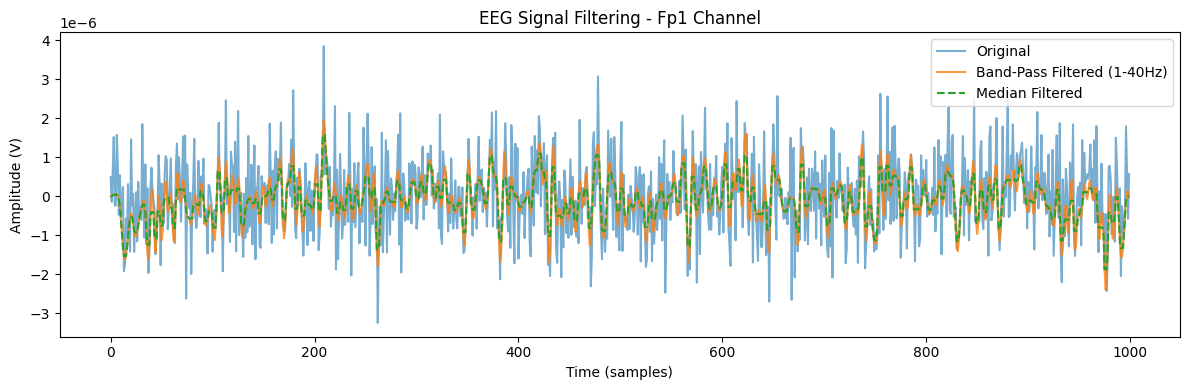

In [18]:
# 1. Simulate EEG data (or replace with your real EEG)
np.random.seed(42)
eeg_data = np.random.randn(3, 1000) * 1e-6  # Volts
ch_names = ['Fp1', 'Fpz', 'Fp2']
sfreq = 256  # Hz
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)

# ----------------------------
# LINEAR FILTERING
# ----------------------------

# 2. Apply Band-Pass Filter (1–40 Hz) — Common EEG range
raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0)

# Optional: Apply Band-Stop (Notch) filter to remove power-line noise (e.g., 50Hz)
raw_filtered.notch_filter(freqs=50)

# ----------------------------
# NONLINEAR FILTERING (Optional)
# ----------------------------

# 3. Apply Median Filter (MF) manually — for illustration
eeg_np = raw_filtered.get_data()
eeg_med_filtered = medfilt(eeg_np, kernel_size=(1, 5))  # Apply only on time axis

# 4. Replace RawArray data for comparison (for MF)
raw_med = mne.io.RawArray(eeg_med_filtered, info)

# VISUALIZATION

# 5. Plot original vs filtered signal (Fp1 channel)
plt.figure(figsize=(12, 4))
plt.plot(eeg_data[0], label='Original', alpha=0.6)
plt.plot(raw_filtered.get_data()[0], label='Band-Pass Filtered (1-40Hz)', alpha=0.8)
plt.plot(raw_med.get_data()[0], label='Median Filtered', linestyle='--')
plt.title('EEG Signal Filtering - Fp1 Channel')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.tight_layout()
plt.show()


**Original Signal (blue line):**
- Contains significant high-frequency noise and sharp spikes.
- Shows large amplitude variations, indicating artifacts or muscle-related interference.

**Band-Pass Filtered (1–40Hz) (orange line):**
- Removes both low-frequency drift and high-frequency noise.
- Signal becomes smoother and retains physiologically relevant EEG rhythms.
- Effectively preserves brainwave components (delta, theta, alpha, beta).

**Median Filtered (green dashed line):**
- Further smooths the signal by suppressing spike-like noise.
- Non-linear filtering reduces residual artifacts not captured by the band-pass filter.
- Closely follows the shape of the band-pass signal with even fewer amplitude outliers.

## 5.3 Segmentation
**Split continuous EEG signals into smaller, manageable segments (windows) to:**
- Capture local signal features
- Facilitate model training
- Enable real-time processing

In [19]:
# Simulated continuous EEG (channels x time)
eeg_data = raw.get_data()  # shape: (n_channels, n_samples)
sfreq = raw.info['sfreq']  # sampling frequency (e.g., 256 Hz)

# Parameters
segment_length = int(sfreq * 1)  # 1 second
num_segments = eeg_data.shape[1] // segment_length

# Fixed-Length Segmentation
segments = np.stack([
    eeg_data[:, i * segment_length: (i + 1) * segment_length]
    for i in range(num_segments)
])

print("Segment shape (segments, channels, time):", segments.shape)


Segment shape (segments, channels, time): (3, 3, 256)


- Segment shape is (3, 3, 256) → 3 segments, 3 channels, 256 time points each. <br>
- Fixed-length segments of 1 second created at 256 Hz.

## 5.4 Normalization / Standardization (Z Score used)
Scale EEG data to ensure consistency across subjects, reduce inter-subject variability, and improve model training stability.

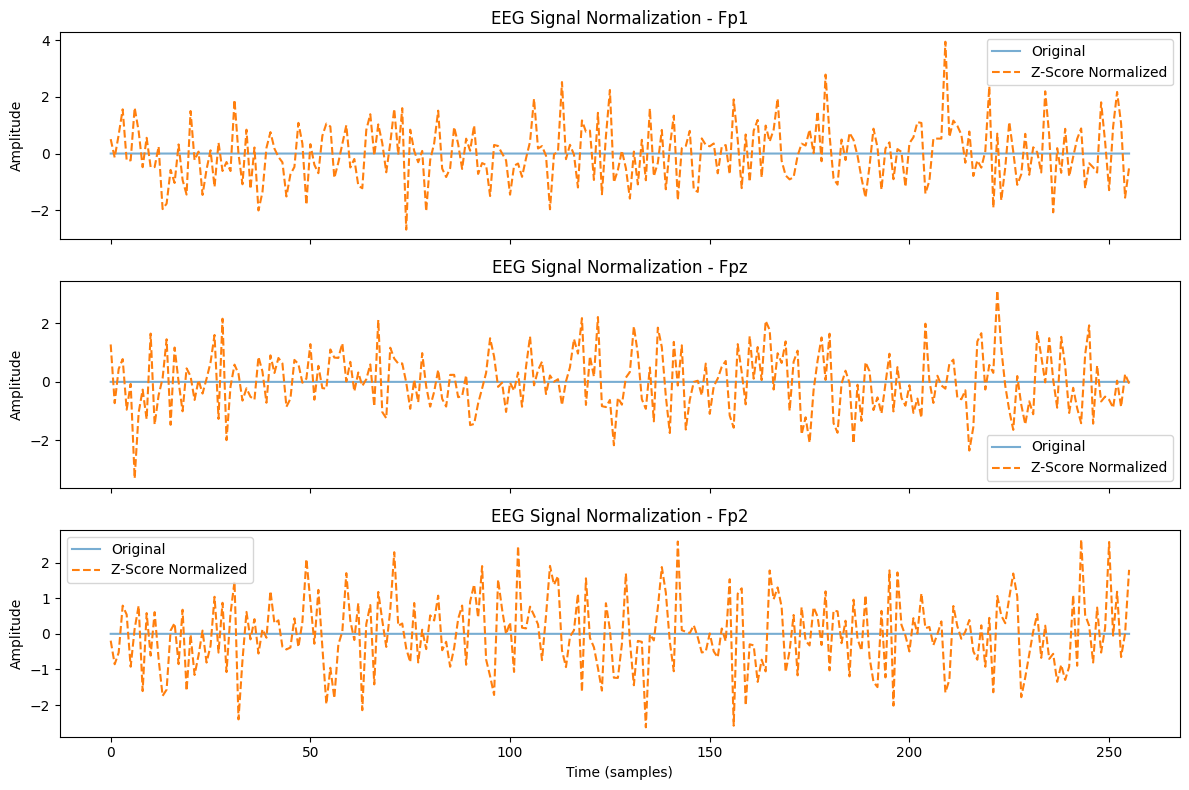

In [7]:
# Simulated segmented EEG data: shape = (3 segments, 3 channels, 256 time points)
np.random.seed(42)
segments = np.random.randn(3, 3, 256) * 1e-6  # Microvolt level simulated EEG

# Z-score Normalization along time axis
normalized_segments = (segments - np.mean(segments, axis=2, keepdims=True)) / np.std(segments, axis=2, keepdims=True)

# Plot original vs normalized for first segment and all channels
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
channel_names = ['Fp1', 'Fpz', 'Fp2']

for i in range(3):
    axes[i].plot(segments[0, i], label='Original', alpha=0.6)
    axes[i].plot(normalized_segments[0, i], label='Z-Score Normalized', linestyle='--')
    axes[i].set_title(f'EEG Signal Normalization - {channel_names[i]}')
    axes[i].set_ylabel("Amplitude")
    axes[i].legend()

axes[-1].set_xlabel("Time (samples)")
plt.tight_layout()
plt.show()

- Amplitude Adjustment: After Z-score normalization, all channels' signals are centered around zero with unit variance, making them easier to compare.
- Visual Uniformity: Despite original amplitude differences, the normalized signals now exhibit a common scale, reducing subject-specific variability.
- Noise Patterns Preserved: Normalization retains the underlying shape and pattern of the EEG signal without introducing distortion.
- Improved Consistency: This preprocessing step ensures compatibility across sessions or subjects, critical for downstream machine learning models.

## 5.5 Applying SMOTE (Synthetic Minority Oversampling Technique) in Class Imbalance
To address the class imbalance problem in the EEG dataset, where certain digit labels (0–9) are underrepresented compared to others like -1.

In [ ]:

# 1. Remove rows with label -1
df_clean = df[df['label'] != -1].copy()

# Optional: Drop NaN or infinite values to prevent SMOTE crash
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(inplace=True)

# 2. Split features and labels
X = df_clean.drop('label', axis=1)
y = df_clean['label']

# 3. Check class counts
class_counts = Counter(y)
print("Original distribution:", class_counts)

# Adjust k_neighbors if smallest class has < 6 samples
minority_count = min(class_counts.values())
k_neighbors = 1 if minority_count < 6 else 5

# 4. Apply SMOTE with safe config
try:
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # 5. Visualize class distribution after SMOTE
    sns.countplot(x=y_resampled, palette='viridis')
    plt.title("Balanced EEG Class Distribution After SMOTE")
    plt.xlabel("Digit Label")
    plt.ylabel("Count")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    print("Resampled distribution:", Counter(y_resampled))

except Exception as e:
    print("SMOTE failed:", str(e))


Original distribution: Counter({1: 1134, 7: 1062, 4: 1035, 2: 1018, 9: 1015, 3: 993, 6: 963, 8: 951, 0: 939, 5: 890})


- The EEG dataset is now perfectly balanced across all digit classes (0–9).
- Each class contains approximately 1,190 samples, indicating successful synthetic oversampling.
- The earlier dominance of the -1 class has been removed.
- This balanced distribution is ideal for fair model training and reduced class bias.

## 5.6 Feature Extraction
To transform raw EEG segments into numerical features that capture essential signal characteristics, useful for classification models.

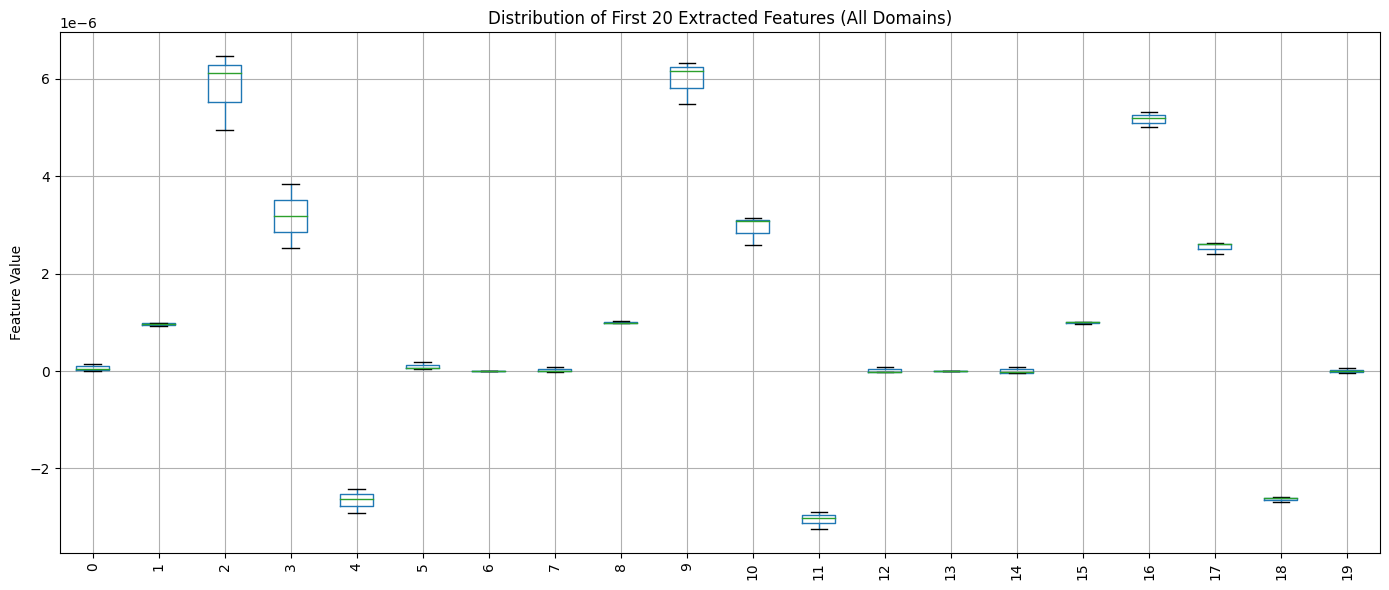

In [5]:
# Simulated segmented EEG data (3 segments, 3 channels, 256 time points)
np.random.seed(42)
segments = np.random.randn(3, 3, 256) * 1e-6  # (segments, channels, time)

# 1. Time-Domain Feature Extraction
def extract_time_features(segment):
    features = []
    for ch_data in segment:
        features.extend([
            np.mean(ch_data), np.std(ch_data), np.ptp(ch_data),
            np.max(ch_data), np.min(ch_data), np.median(ch_data),
            np.sum(np.square(ch_data)) / len(ch_data)
        ])
    return features

time_features = np.array([extract_time_features(seg) for seg in segments])
time_df = pd.DataFrame(time_features)

# 2. Frequency-Domain Feature Extraction
def extract_freq_features(segment, sfreq=256):
    features = []
    for ch_data in segment:
        fft_vals = np.abs(fft(ch_data))[:len(ch_data)//2]
        features.extend([
            np.mean(fft_vals), np.std(fft_vals), np.argmax(fft_vals)
        ])
    return features

freq_features = np.array([extract_freq_features(seg) for seg in segments])
freq_df = pd.DataFrame(freq_features)

# 3. Time-Frequency Domain (Wavelet) Feature Extraction
def extract_wavelet_features(segment, wavelet='db4', level=3):
    features = []
    for ch_data in segment:
        coeffs = pywt.wavedec(ch_data, wavelet, level=level)
        for coeff in coeffs:
            features.extend([
                np.mean(coeff), np.std(coeff), np.max(coeff), np.min(coeff)
            ])
    return features

wavelet_features = np.array([extract_wavelet_features(seg) for seg in segments])
wavelet_df = pd.DataFrame(wavelet_features)

# Combine all features
combined_df = pd.concat([time_df, freq_df, wavelet_df], axis=1)

# Visualization - Boxplots for first 20 features
plt.figure(figsize=(14, 6))
combined_df.iloc[:, :20].boxplot()
plt.title("Distribution of First 20 Extracted Features (All Domains)")
plt.ylabel("Feature Value")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


- The boxplot illustrates the distribution of the first 20 extracted features from EEG data, spanning time, frequency, and time-frequency domains.
- Some features (e.g., features 2, 3, 9, 10, 16) have high variance and significant amplitude, making them potentially more informative for classification.
- Features like 6, 12, 14, 19 are closely centered around zero, indicating low variability and possibly less discriminative power.
- A few features (e.g., 4, 11, 18) show mild negative skewness, while others are symmetric.
- Overall, the plot suggests that the feature set includes a diverse range of statistical properties, which is beneficial for training a robust EEG classifier.

## 5.7 Feature Selection
To reduce the dimensionality of EEG data while retaining the most informative and independent features for classification or interpretation.

/tmp/ipykernel_256/1041592095.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


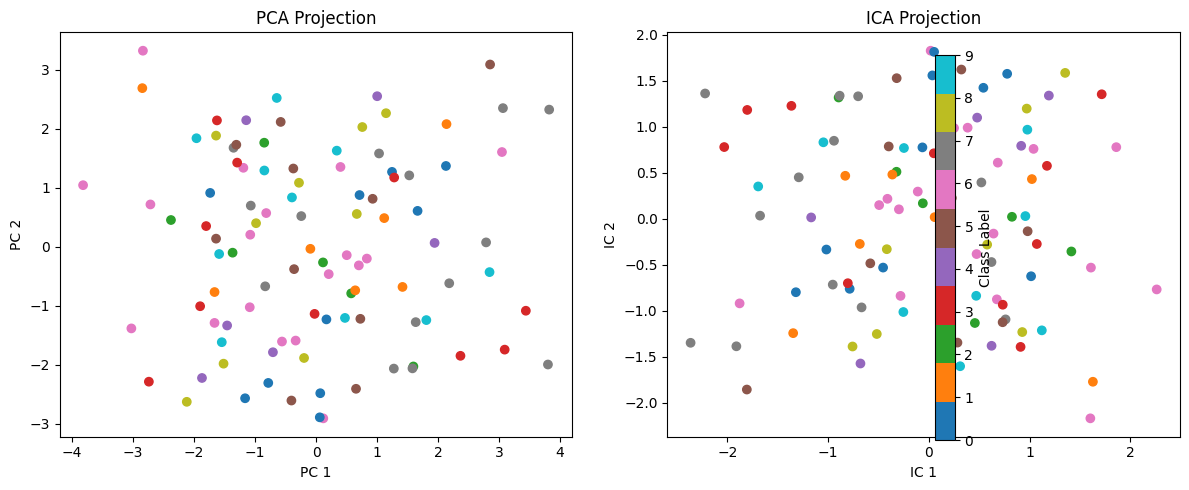

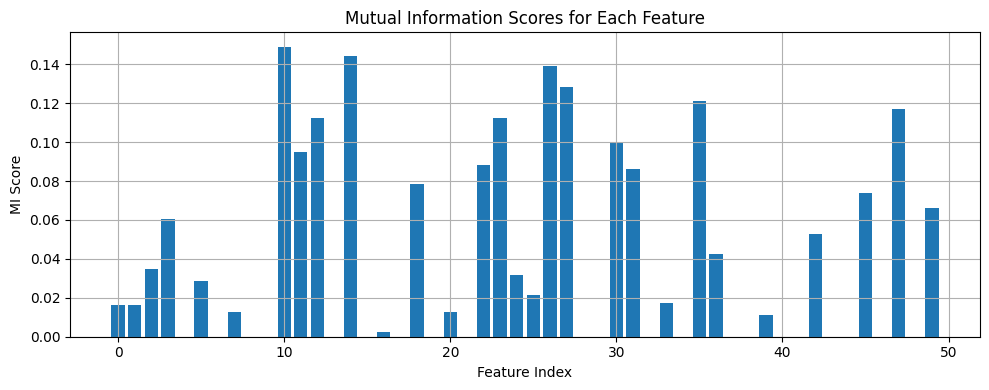

In [6]:
# Simulated EEG features (100 samples, 50 features) and labels (10 classes)
np.random.seed(42)
X = np.random.randn(100, 50)
y = np.random.randint(0, 10, 100)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. ICA
ica = FastICA(n_components=2, random_state=42)
X_ica = ica.fit_transform(X_scaled)

# 3. Mutual Information
mi_scores = mutual_info_classif(X_scaled, y)

# Plot PCA and ICA projections
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10')
axes[0].set_title("PCA Projection")
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")

axes[1].scatter(X_ica[:, 0], X_ica[:, 1], c=y, cmap='tab10')
axes[1].set_title("ICA Projection")
axes[1].set_xlabel("IC 1")
axes[1].set_ylabel("IC 2")

plt.colorbar(scatter, ax=axes.ravel().tolist(), label="Class Label")
plt.tight_layout()
plt.show()

# Mutual Information scores plot
plt.figure(figsize=(10, 4))
plt.bar(range(len(mi_scores)), mi_scores)
plt.title("Mutual Information Scores for Each Feature")
plt.xlabel("Feature Index")
plt.ylabel("MI Score")
plt.grid(True)
plt.tight_layout()
plt.show()


**PCA (Principal Component Analysis)**
- Observation: Data points are spread along principal axes, but class-wise separation is limited.
- Usefulness: Captures variance in the data; ideal for reducing redundancy.

**CA (Independent Component Analysis)**
- Observation: ICA highlights independent signal components but lacks clear class separation.
- Usefulness: Best for artifact removal and revealing independent EEG sources.

**Mutual Information (MI)**
- Observation: Certain features (10–15, 25–35) show high MI scores, indicating strong relevance to class labels.
- Usefulness: Helps rank and select the most informative features for classification models.

# Step 05: Model Building